# ML FizzBuzz Test

This notebook represents a machine learning test to classify natural numbers into four classes: “None”, “Fizz”, “Buzz”, and “FizzBuzz”.

In [26]:
# Import general packages
import os
import pandas as pd
import numpy as np
from numpy import ndarray

# Ignore deprecation warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Local package created to provide clean code
from fizzbuzz_classification.data_loader import DataLoader
from fizzbuzz_classification.data_visualizer import plot_features

## Data understanding

### Data collection

The dataset was created by generating natural numbers and label them according to an specific criteria. The dataset consists of one file with two columns: one for the number and another one for the label.

The following code read data from the file and verifies if data satifies the problem description and requirements.

- Natural numbers
- 4 Labels: “None”, “Fizz”, “Buzz”, and “FizzBuzz”

In [27]:
# Load and preprocess the data
loader = DataLoader()
set_length = 100
loader.generate_data(set_length)
df_data = loader.load_data('original', set_length)

display(df_data.info())
labels = df_data['label'].unique()
print(f'Labels: {labels}')
display(df_data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   number  100 non-null    int64 
 1   label   100 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


None

Labels: ['None' 'Fizz' 'Buzz' 'FizzBuzz']


,number,label
0,1,None
1,2,None
2,3,Fizz
3,4,None
4,5,Buzz


### Exploratory data analysis (EDA)

Perform exploratory data analysis (EDA) to understand the distribution, relationships, and patterns in the data. Visualizations can help identify insights and guide feature engineering.

In [28]:
# Print a summary of the dataset
print("Dataset Summary:")
display(df_data.describe())
print("Labels distribution")
labels_count = df_data.groupby('label').size()
labels_count = labels_count.sort_values(ascending = False)
print(labels_count)

Dataset Summary:


,number
count,100.000000
mean,50.500000
std,29.011492
min,1.000000
25%,25.750000
50%,50.500000
75%,75.250000
max,100.000000


Labels distribution
label
None        53
Fizz        27
Buzz        14
FizzBuzz     6
dtype: int64


The labels distribution indicates a high imbalance. Therefore, while training, this problem must be considered.

 It is important to remark that, since the data is self-generated, there is no missing data, outliers or other problems that could arise from real data. Therefore, skills to overcome these problems are not tested here. However some plotting skills are used in order to get a visual representation of the data in order to extract some features.

<Figure size 640x480 with 0 Axes>

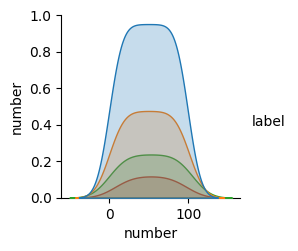

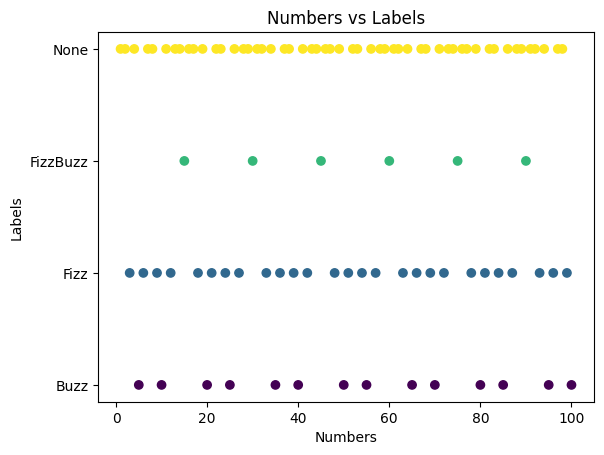

In [29]:
# Plot data features by label
plot_features(df_data)

The analysis of the given dataset reveals that it is composed of four distinct time series, each being sampled at different frequencies. The time series are mutually exclusive, meaning that at each time instant, only one time series is being sampled. The goal is to determine which time series will be sampled at a given time instant. Upon examining the patterns displayed by the data points in each class, it becomes evident that classes 'Fizz', 'Buzz', and 'FizzBuzz' are sampled at regular intervals, whereas class 'None' lacks a clear pattern. This leads to the inference that the numbers have been categorized based on their sampling frequency. Since periodicity is observed in the time series, information concerning their frequencies can be extracted from the data. Instead of directly dealing with frequency, a focus is placed on time periods. Given the presence of multiple periods within the time series, the smallest common periods that are shared among them are going to be identified.

In order to improve the accuracy of the classification model, it would be beneficial to calculate a feature that captures information on the periods of each class. This would help to better distinguish between the different classes and enhance the overall performance of the model.

## Data transformation

In the process of building the classification model, data transformation is necessary to create features that can be utilized by the models. Additionally, some new features may be generated. While each model has specific data requirements, there is a common stage of data transformation that is generally applied. This stage involves the following steps:

- Adding new features by transforming original data.
- Normalizing features to ensure consistency and uniformity in their scales.

In [30]:
features, labels = loader.load_data('original', set_length, return_df=False)

In the following code, a transformation will be executed to determine whether a time instant is considered as part of a time series sample. First, the smallest periods (greater than one) for each time series will be calculated, and to indicate the alignment with a specific time series, the modulus of each time instant will be calculated with respect to all periods derived from all time series.

In [31]:
from fizzbuzz_classification.data_preprocessing import transform_series_to_periods

df_period, period_estimators = transform_series_to_periods(df_data, return_estimator=True)
df_period['label'] = df_data['label']
display(df_period.info())
display(df_period.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   number_mod3  100 non-null    int32
 1   number_mod5  100 non-null    int32
 2   label        100 non-null    int32
dtypes: int32(3)
memory usage: 1.3 KB


None

,number_mod3,number_mod5,label
0,1,1,3
1,2,2,3
2,0,3,1
3,1,4,3
4,2,0,0


<Figure size 640x480 with 0 Axes>

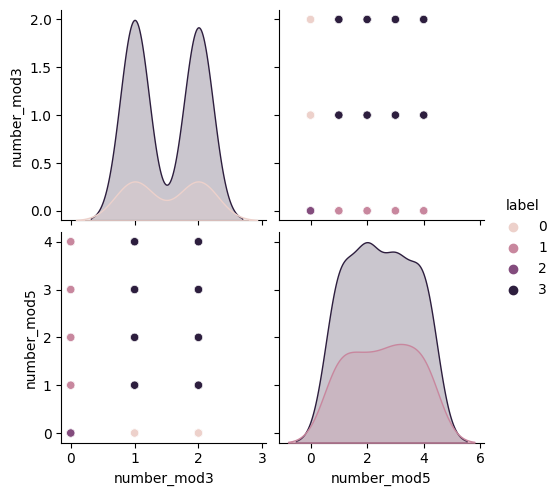

<Figure size 640x480 with 0 Axes>

In [32]:
# Plot data features by label
plot_features(df_period)

In [33]:
# Save new features dataframe
loader.save_data(df_period, 'preprocessed', set_length)

Partial Conclusions: The selected features for the classification model include frequency features and natural numbers. During the modeling phase, both sets of features will be incorporated to assess the feasibility and effectiveness of their inclusion in feature calculations.

## Model creation

In this section, the chosen models are fitted to classify the numbers in order to identify models with higher performance. To facilitate this task, we begin by importing necessary packages.

In [34]:
# Load larger dataset
set_length = 1000
loader.generate_data(set_length)
features, labels = loader.load_data('original', set_length, return_df=False)

In [35]:
# Transform labels to integer
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

In [36]:
from fizzbuzz_classification.modeling import tune_hyperparam, train_and_test_classifier, test_estimator, weights_for_imbalance_classes
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

### Model structures

In model creation, experiment were design and executed with different models structures to find the best fit for the problem. These models are:
- Support Vector Machine

#### SVM

In [37]:
# Initialize an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)

### Model training

In this step, the train, test and validation sets are created.

#### Imbalance classes

In [38]:
# Using weights to approach imbalance class problem
weights = weights_for_imbalance_classes(labels)

In [39]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(features, labels, weights, test_size=0.2, random_state=42)

In [40]:
# Set fit parameters
fit_params = {'sample_weight': weights_train}

In [41]:
# Set saving directory for models
model_save_dir = os.path.join(os.getcwd(), 'fizzbuzz_classification/models/')
if not os.path.exists(model_save_dir):
    os.mkdir(model_save_dir)

##### Train and test SVM classifier

In [42]:
# Define the hyperparameter grid to search
# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf', 'poly'],
#     'gamma': [0.1, 1, 'scale', 'auto']
# }
param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear']
}

params = tune_hyperparam(svm_classifier, X_train, y_train, X_test, y_test, param_grid, 5, 3, fit_params)

Loading model
Testing model
Evaluate model
Testing model
Evaluate model
Accuracy: 16.50%

Classification Report:
               precision    recall  f1-score   support

           0       0.13      0.48      0.21        29
           1       0.20      0.36      0.26        53
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00        97

    accuracy                           0.17       200
   macro avg       0.08      0.21      0.12       200
weighted avg       0.07      0.17      0.10       200



c:\Users\Adri\PythonEnv\datasci_classification\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Adri\PythonEnv\datasci_classification\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Adri\PythonEnv\datasci_classification\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

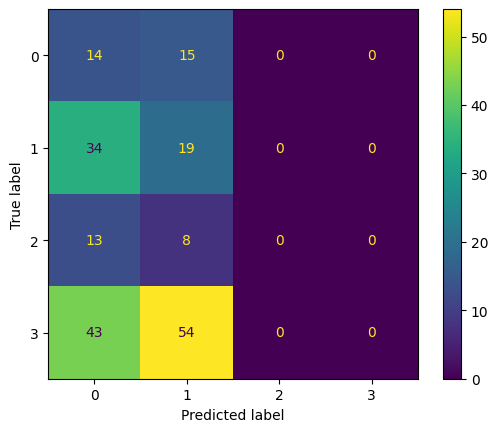

In [43]:
# Train and test svm classifier
svm_classifier, train_accuracy, test_accuracy = train_and_test_classifier(svm_classifier, X_train, y_train, X_test, y_test, params, fit_params)

Testing model
Evaluate model
Accuracy: 27.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.27      1.00      0.43        27
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        53

    accuracy                           0.27       100
   macro avg       0.07      0.25      0.11       100
weighted avg       0.07      0.27      0.11       100



c:\Users\Adri\PythonEnv\datasci_classification\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Adri\PythonEnv\datasci_classification\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Adri\PythonEnv\datasci_classification\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

0.27

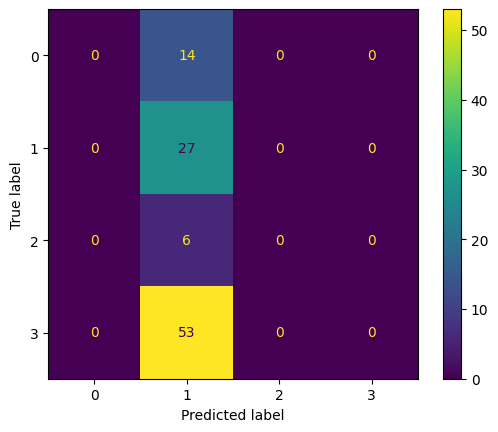

In [44]:
set_length = 100
features, labels = loader.load_data('original', set_length, return_df=False)
labels = encoder.transform(labels)
test_estimator(svm_classifier, features, labels)

## Model deployment

Model deployment for classification using scikit-learn's pipeline offers an efficient way to seamlessly transition a trained machine learning model into production. This integrated approach simplifies data preprocessing, feature engineering, and model inference, making it easier to maintain and scale the deployed system.

In [45]:
# Import pipeline from sklearn
from sklearn.pipeline import Pipeline

# Add preprocessing and classification steps to a single pipeline
pipe = Pipeline(steps=[('classifier', svm_classifier)])
# pipe = pipe.fit(X_train, y_train, **fit_params)
y_pred = pipe.predict(X_test)

In [46]:
y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1])